# Introduction
In this laboratory we will get our hands dirty working with Large Language Models (e.g. GPT and BERT) to do various useful things. I you haven't already, it is highly recommended to:

+ Read the [Attention is All you Need](https://arxiv.org/abs/1706.03762) paper, which is the basis for all transformer-based LLMs.
+ Watch (and potentially *code along*) with this [Andrej Karpathy video](https://www.youtube.com/watch?v=kCc8FmEb1nY) which shows you how to build an autoregressive GPT model from the ground up.

# Exercise 1: Warming Up
In this first exercise you will train a *small* autoregressive GPT model for character generation (the one used by Karpathy in his video) to generate text in the style of Dante Aligheri. Use [this file](https://archive.org/stream/ladivinacommedia00997gut/1ddcd09.txt), which contains the entire text of Dante's Inferno (**note**: you will have to delete some introductory text at the top of the file before training). Train the model for a few epochs, monitor the loss, and generate some text at the end of training. Qualitatively evaluate the results 

# Exercise 2: Working with Real LLMs

Our toy GPT can only take us so far. In this exercise we will see how to use the [Hugging Face](https://huggingface.co/) model and dataset ecosystem to access a *huge* variety of pre-trained transformer models.

## Exercise 2.1: Installation and text tokenization

First things first, we need to install the [Hugging Face transformer library](https://huggingface.co/docs/transformers/index):

    conda install -c huggingface -c conda-forge transformers
    
The key classes that you will work with are `GPT2Tokenizer` to encode text into sub-word tokens, and the `GPT2LMHeadModel`. **Note** the `LMHead` part of the class name -- this is the version of the GPT2 architecture that has the text prediction heads attached to the final hidden layer representations (i.e. what we need to **generate** text). 

Instantiate the `GPT2Tokenizer` and experiment with encoding text into integer tokens. Compare the length of input with the encoded sequence length.

**Tip**: Pass the `return_tensors='pt'` argument to the togenizer to get Pytorch tensors as output (instead of lists).

## Exercise 2.2: Generating Text

There are a lot of ways we can, given a *prompt* in input, sample text from a GPT2 model. Instantiate a pre-trained `GPT2LMHeadModel` and use the [`generate()`](https://huggingface.co/docs/transformers/v4.27.2/en/main_classes/text_generation#transformers.GenerationMixin.generate) method to generate text from a prompt.

**Note**: The default inference mode for GPT2 is *greedy* which might not results in satisfying generated text. Look at the `do_sample` and `temperature` parameters.

# Exercise 3: Reusing Pre-trained LLMs (choose one)

Choose **one** of the following exercises (well, *at least* one). In each of these you are asked to adapt a pre-trained LLM (`GPT2Model` or `DistillBERT` are two good choices) to a new Natural Language Understanding task. A few comments:

+ Since GPT2 is a *autoregressive* model, there is no latent space aggregation at the last transformer layer (you get the same number of tokens out that you give in input). To use a pre-trained model for a classification or retrieval task, you should aggregate these tokens somehow (or opportunistically select *one* to use).

+ BERT models (including DistillBERT) have a special [CLS] token prepended to each latent representation in output from a self-attention block. You can directly use this as a representation for classification (or retrieval).

+ The first *two* exercises below can probably be done *without* any fine-tuning -- that is, just training a shallow MLP to classify or represent with the appropriate loss function.

# Exercise 3.1: Training a Text Classifier (easy)

Peruse the [text classification datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:text-classification&sort=downloads). Choose a *moderately* sized dataset and use a LLM to train a classifier to solve the problem.

**Note**: A good first baseline for this problem is certainly to use an LLM *exclusively* as a feature extractor and then train a shallow model.

# Exercise 3.2: Training a Question Answering Model (harder)

Peruse the [multiple choice question answering datasets on Hugging Face](https://huggingface.co/datasets?task_categories=task_categories:multiple-choice&sort=downloads). Chose a *moderately* sized one and train a model to answer contextualized multiple-choice questions. You *might* be able to avoid fine-tuning by training a simple model to *rank* the multiple choices (see margin ranking loss in Pytorch).

# Exercise 3.3: Training a Retrieval Model (hardest)

The Hugging Face dataset repository contains a large number of ["text retrieval" problems](https://huggingface.co/datasets?task_categories=task_categories:text-retrieval&p=1&sort=downloads). These tasks generally require that the model measure *similarity* between text in some metric space -- naively, just a cosine similarity between [CLS] tokens can get you pretty far. Find an interesting retrieval problem and train a model (starting from a pre-trained LLM of course) to solve it.

**Tip**: Sometimes identifying the *retrieval* problems in these datasets can be half the challenge. [This dataset](https://huggingface.co/datasets/BeIR/scifact) might be a good starting point.

## Import Libraries

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

## Hyperparameters

In [2]:
BATCH_SIZE = 16
BLOCK_SIZE = 256
EPOCHS = 10
N_EMBD = 512
N_HEAD = 6
N_LAYER = 6
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {DEVICE}")

Using device: cuda


## Loading data

In [3]:
class InfernoDataset(torch.utils.data.Dataset):
    def __init__(self, block_size, path='dante_inferno.txt', split='train'):
        with open(path, 'r') as f:
            text = f.read()
            text = list(text)
            if split == 'train':
                self.text = text[:int(len(text)*0.9)]
            elif split == 'val':
                self.text = text[int(len(text)*0.9):]
            else:
                raise ValueError("split must be 'train' or 'val'")
            self.block_size = block_size
            self.vocab_size = len(set(self.text))
            self.stoi = { ch:i for i,ch in enumerate(set(self.text)) }
            self.itos = { i:ch for i,ch in enumerate(set(self.text)) }
            self.data = torch.tensor([self.stoi[c] for c in self.text], dtype=torch.long)
            self.split = split
            self.train_size = int(0.9 * len(self.data))

    def __len__(self):
        return len(self.data) - self.block_size

    def __getitem__(self, idx):
        x = self.data[idx:idx+self.block_size] if idx + self.block_size < len(self.data) else self.data[idx:]
        return x
    
    def encode(self, text):
        return torch.tensor([self.stoi[c] for c in text], dtype=torch.long)
    
    def decode(self, indices):
        return ''.join([self.itos[i.item()] for i in indices])
    
def GetBatch(dataset, batch_size, device):
    idx = torch.randint(len(dataset), (batch_size,))
    x = torch.stack([dataset.data[i:i+BLOCK_SIZE] for i in idx])
    y = torch.stack([dataset.data[i+1:i+BLOCK_SIZE+1] for i in idx])
    x, y = x.to(device), y.to(device)
    return x, y

In [4]:
dataset_train = InfernoDataset(BLOCK_SIZE, path='dante_inferno.txt', split='train')
dataset_val = InfernoDataset(BLOCK_SIZE, path='dante_inferno.txt', split='val')
x, y = GetBatch(dataset_train, BATCH_SIZE, device=DEVICE)
print(x.shape)
print(x[0, :])
print(dataset_train.decode(x[0, :]))
print(y.shape)
print(y[0, :])
print(dataset_train.decode(y[0, :]))

torch.Size([16, 256])
tensor([21, 15,  0, 55, 24, 24, 22, 48,  0, 25, 47, 53, 40, 27, 53, 25, 40, 21,
        15, 53, 45, 52,  2, 31, 40,  2, 40, 22, 48,  0, 25, 47, 53, 40, 27, 53,
        25, 40, 27,  0, 45, 42,  0, 25,  2, 31, 24, 40, 40, 27, 53, 25, 40, 21,
         0, 45, 52, 48, 15, 12, 40,  2, 40, 27, 53, 25, 40, 27,  2, 25, 25, 12,
        40, 47, 12, 40, 27,  0, 26, 21,  2, 36, 36,  0, 31, 24, 40, 40,  2, 40,
        27, 53, 25, 40, 27, 53, 26,  2, 40, 25, 53, 26, 21, 15,  0, 36, 12, 40,
         2, 40, 27, 53, 25, 40, 12, 26, 21, 15,  0, 25,  2, 55, 24, 24, 25,  2,
        38, 40, 35, 12,  0, 54, 40, 27, 53, 25, 40, 26, 12, 54, 40, 47, 12, 41,
         2, 15, 26,  0, 40, 27,  2, 25, 25,  0, 45,  2, 36, 36,  0, 24, 40, 40,
        27,  0, 41,  0, 36, 12,  2, 15, 40, 41, 12, 47, 12, 40, 45, 48, 53, 41,
         2, 15, 40, 25,  2, 38, 40, 42,  2, 47, 53, 25, 12, 31, 24, 40, 40, 25,
         2, 38, 40, 25,  0, 41,  2, 40,  0, 40, 26,  2, 35, 25, 53, 40, 47, 12,
        40, 21,  2

## Toy GPT Model

In [ ]:
class LinearLayer(nn.Module):
    def __init__(self, in_features, mid_features, out_features, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(in_features, mid_features),
            nn.ReLU(),
            nn.Linear(mid_features, out_features),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Attention_Head(nn.Module):

    def __init__(self, d_model, d_k, dropout=0.2):
        super().__init__()
        self.key = nn.Linear(d_model, d_k, bias=False)
        self.query = nn.Linear(d_model, d_k, bias=False)
        self.value = nn.Linear(d_model, d_k, bias=False)
        self.register_buffer("tril", torch.tril(torch.ones(BLOCK_SIZE, BLOCK_SIZE)))
        self.d_k = d_k
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # input of size (batch, channels, time-step)
        # output of size (batch, time-step, d_k)
        k = self.key(x)   # (B, T, d_k)
        q = self.query(x) # (B, T, d_k)

        w = torch.matmul(q, k.transpose(-2, -1)) # (B, T, d_k) @ (B, d_k, T) -> (B, T, T)
        w = w / (self.d_k**0.5)
        w = F.softmax(w, dim=-1) # (B, T, T)
        w = self.dropout(w) # (B, T, T)
        v = self.value(x) # (B, T, d_k)
        out = w @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, d_model, d_k, dropout=0.2):
        super().__init__()
        self.heads = nn.ModuleList([Attention_Head(d_model, d_k) for _ in range(num_heads)])
        self.proj = nn.Linear(d_k * num_heads, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1) # (B, T, d_k * num_heads)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):

    def __init__(self, n_embd, dropout=0.2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class AddAndNorm(nn.Module):
    def __init__(self, mod, size):
        super().__init__()
        self.mod = mod
        self.ln = nn.LayerNorm(size)

    def forward(self, x):
        return x + self.mod(self.ln(x))

class TransformerBlock(nn.Module):
    def __init__(self, n_embd, n_head, dropout=0.2):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.multi_att = AddAndNorm(MultiHeadAttention(n_head, n_embd, head_size, dropout), n_embd)
        self.ffwd = AddAndNorm(FeedForward(n_embd, dropout), n_embd)

    def forward(self, x):
        out = self.multi_att(x)
        out = self.ffwd(out)
        return out
        

class GPT(nn.Module):
    def __init__(self, dict_size, n_embd, block_size, n_layer, n_head, device, dropout=0.2):
        super().__init__()
        self.token_embedding_table = nn.Embedding(dict_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[TransformerBlock(n_embd, n_head, dropout=dropout) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) 
        self.lm_head = LinearLayer(n_embd, n_embd, dict_size, dropout=dropout)
        self.device = device
        self.block_size = block_size
        self.n_embd = n_embd
        self.n_layer = n_layer
        self.n_head = n_head

    def forward(self, idx):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        return logits #, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

## Training Pipeline

In [14]:
model = GPT(dict_size=dataset_train.vocab_size, n_embd=N_EMBD, block_size=BLOCK_SIZE, n_layer=N_LAYER, n_head=N_HEAD, device=DEVICE)
m = model.to(DEVICE)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
loss_fn = F.cross_entropy
check = 50
for epoch in range(500):
    model.train()
    x, y = GetBatch(dataset_train, BATCH_SIZE, device=DEVICE)
    logits = model(x)
    loss = loss_fn(logits.view(-1, dataset_train.vocab_size), y.view(-1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch % check == 0:
        x_val, y_val = GetBatch(dataset_val, BATCH_SIZE, device=DEVICE)
        with torch.no_grad():
            model.eval()
            logits_val = model(x_val)
            loss_val = loss_fn(logits_val.view(-1, dataset_train.vocab_size), y_val.view(-1))
            print(f"Epoch {epoch}: train_loss = {loss.item():.4f}, val_loss = {loss_val.item():.4f}")
torch.save(model.state_dict(), 'gpt_inferno.pth')

19.333689 M parameters
Epoch 0: train_loss = 4.0546, val_loss = 4.0658
Epoch 50: train_loss = 2.7874, val_loss = 4.8281
Epoch 100: train_loss = 2.7060, val_loss = 5.1059
Epoch 150: train_loss = 2.6788, val_loss = 5.3634
Epoch 200: train_loss = 2.6494, val_loss = 5.5397
Epoch 250: train_loss = 2.6282, val_loss = 5.6641
Epoch 300: train_loss = 2.6088, val_loss = 5.7921
Epoch 350: train_loss = 2.6633, val_loss = 5.6813
Epoch 400: train_loss = 2.6318, val_loss = 5.7574
Epoch 450: train_loss = 2.5937, val_loss = 5.8116


In [10]:
model = GPT(dict_size=dataset_train.vocab_size, n_embd=N_EMBD, block_size=BLOCK_SIZE, n_layer=N_LAYER, n_head=N_HEAD, device=DEVICE)
model.load_state_dict(torch.load('gpt_inferno.pth'))

<All keys matched successfully>

In [15]:
init_context = torch.zeros((1,1), dtype=torch.long, device=DEVICE)
max_tokens = 500
m.eval()
new_text = m.generate(init_context, max_new_tokens=max_tokens)
print("Generated text:")
print(dataset_train.decode(new_text[0, :]))

Generated text:
aaaaadaa,ascalaacarbalacalalaquaa aagna asa,aalava palosaQacacasa,zalaaavapabapiappaza <anana,anaganaballsacaa pa a ana a lala`a  dmagoimala  a ialo.agaia va'anauaraga lagasia
talasbanalanava a
'a
 'anaLasa ra tIfa ana e ota la a,a cati Ma
a -apa 'XaMala,a dalanala ltanvata a mia
 
 amasenarappata'a a'ara ma
 alta
Cra Ganamvara mavamia

Tarada la,calgrama, madana M'o,
  iarabapalada  liauovadarava ralpedpa  :ala, alam'zila,aba
Lalda vzazagvanacgguanta uararalaga ga.


cava;a ualagPa e'lla

ui cea


As we can notice the model does not have good performance, the generated text is chaotic, one thing I noticed is the fact that if I try to train with some other epochs, the model overfits causing the generated text to be composed by a single repeated letter because the output probability distribution is peaked.

To reach better performances non-toy models should be used, let's take a look to Hugging Face models.

# Hugginface Models

Let's try the tokenizer

In [51]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
import matplotlib.pyplot as plt
import numpy as np


tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
print(tokenizer("Hello world !", return_tensors="pt")["input_ids"])
print(tokenizer("Hello, world", return_tensors="pt")["input_ids"])
print(tokenizer(" Hello world", return_tensors="pt")["input_ids"])

tensor([[15496,   995,  5145]])
tensor([[15496,    11,   995]])
tensor([[18435,   995]])


From this simple example we can estabilish that the tokenizer takes into account primarily the number of words and punctuation, let's try to see a graph summarizing the magnitutde of the compression

In [ ]:
def encode_plot(tokenizer, string_list):
    x = [len(string_list[i]) for i in range(len(string_list))]
    y = [tokenizer(string_list[i], return_tensors="pt")["input_ids"].shape[1] for i in range(len(string_list))]
    ratio = [y[i] / x[i] for i in range(len(x))]
    plt.plot(x, y)
    plt.xlabel('String Length')
    plt.ylabel('Token Count')
    plt.title(f'Token Count vs String Length (Ratio = {np.mean(ratio):.2f})')

def generate_string_list(model, tokenizer):
    string_list = []
    model.to(DEVICE)
    for i in range(10, 200, 10):
        init_context = torch.tensor(i, dtype=torch.long, device=DEVICE).view(1, 1)
        generated_text = tokenizer.decode(model.generate(init_context, max_new_tokens=i)[0], skip_special_tokens=True)
        string_list.append(generated_text)
    return string_list

In [53]:
model = GPT2LMHeadModel.from_pretrained("openai-community/gpt2")
# do_sample controls whether to use sampling or greedy decoding
# temperature modulate next token probabilites
# top_k is the probability for filtering the vocabulary
# top_p condition which tokens to keep for the next step (they must sum up to at least p)
new_text_id = model.generate(
    input_ids=tokenizer("Hello world", return_tensors="pt")["input_ids"],
    max_length=50,
    do_sample=True,
    top_k=50,
    top_p=0.95,
    num_return_sequences=1
)
new_text_str = tokenizer.decode(new_text_id[0], skip_special_tokens=True)
print(new_text_str)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Hello world! What does a 'Wargaming 101' look like?"

"A 'Wargaming 101', like any decent 'mainstream' hobbyist, you'd think. So let's see how you do it…




In [54]:
list_strings = generate_string_list(model, tokenizer)

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generati

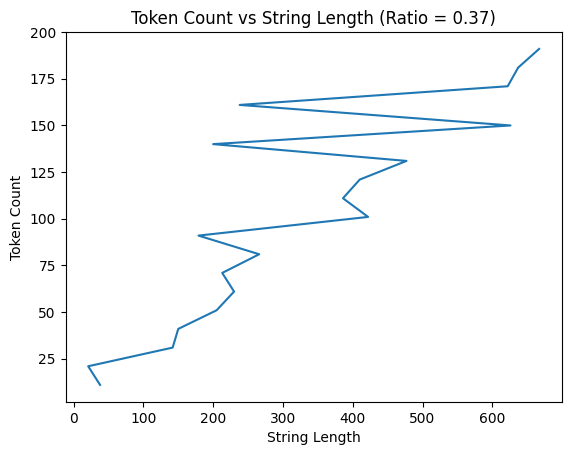

In [55]:
encode_plot(tokenizer, list_strings)

We can notice at first glance that approximately the number of token grows linaerly with the length of the string, but clearly it is not a fixed rule, as it depends on the kind of string

Now we try to play with the temperature parameter of the model

In [57]:
T = np.arange(0.1, 1.1, 0.1)
context = tokenizer("Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited", return_tensors="pt")["input_ids"].to(DEVICE)
for t in T:
    outputs = model.generate(context, max_new_tokens=50, do_sample=True, top_k=50, temperature=t, top_p=0.95)
    print(f"\n° Generated text (temperature = {t}):")
    print(f"{tokenizer.decode(outputs[0])}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.1):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and The Last Man on Earth. I'm not sure if I'm going to be able to get through all of them, but I'm going to be able to get through them.

I'm not sure if I'm going to be


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.2):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and The Last Man on Earth. I'm not sure if I'm going to be able to get through all of them all, but I'm sure I'll be able to get through them all.

I'm not sure if I'm


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.30000000000000004):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and The Great Escape.

I'm not sure if I'm going to be able to get through all of them, but I'm sure I'll be able to get through the rest of them.

I've been reading a lot


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.4):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited and I'm Not A Celebrity. I've been listening to them for years and I'm not sure what to say.

I've been listening to them for years and I'm not sure what to say.

I'm not a celebrity


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.5):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and the album's title track.

I also have a very large collection of albums that I've written, but I'm not a fan of the genre. I think the genre is too much of a mess for me to write a book


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.6):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and the underrated, but still a lot of fun, track "Blackout."

In the meantime, I'm writing a blog post about this album that you can read here, but I'm also making a special post about this album to


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.7000000000000001):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and The Beatles.

I was also an avid collector of Bob Dylan and Tom Petty. I have to admit that I had a lot of fun with Bob and the band during their early years. Bob's music was so unique and so beautiful


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.8):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and the last album is The Last Wish, which I love.


I also like the album title, which I would've thought was a bit more of a homage to the album titles of other albums. If you've ever listened to the


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.



° Generated text (temperature = 0.9):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited and much more. My favorite songs of all time are The Music Never Stopped and I Love You, Don't Let My Friends Down (with all the great songs I have), The World Is Not Enough and even The Best of John Cale.

° Generated text (temperature = 1.0):
Some of my favorite albums are Kid A, Dark Side of the Moon, The Age of Adz, Highway 61 Revisited, and many others. My second favorite is my own personal favorite and the best I can share with you is this (on my YouTube channel, at least):

The first year my mother came to town was quite a while ago, and I


As we can see with the growth of the temperature the likelihood of getting repetead phrases decrease, while it seems to be a in increase of the coherence to the topic even though once reached T=1, the model starts adding nonsense

# Exercise 3.1

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from datasets import load_dataset
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer

The code works with both imdb and rotten tomatoes datasets, just change the string below

In [3]:
DATASET_STR = 'rotten_tomatoes' # 'rotten_tomatoes'
EPOCHS = 20
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
TOKEN_LENGTH = 512
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
dataset_path = 'stanfordnlp/imdb' if DATASET_STR == 'imdb' else 'cornell-movie-review-data/rotten_tomatoes'
dataset = load_dataset(dataset_path)
ds_train = dataset["train"]
ds_test = dataset["test"]
if DATASET_STR == 'rotten_tomatoes':
    ds_val = dataset["validation"]

In [5]:
positive_samples = ds_train.filter(lambda x: x["label"] == 1)
negative_samples = ds_train.filter(lambda x: x["label"] == 0)
print(f"Number of positive samples: {len(positive_samples)}")
print(f"Number of negative samples: {len(negative_samples)}\n")

print(f"Positive example:")
print(f"Text: {positive_samples[0]['text']}")
print(f"Label: {positive_samples[0]['label']}\n")

print(f"Negative example:")
print(f"Text: {negative_samples[0]['text']}")
print(f"Label: {negative_samples[0]['label']}")

Number of positive samples: 4265
Number of negative samples: 4265

Positive example:
Text: the rock is destined to be the 21st century's new " conan " and that he's going to make a splash even greater than arnold schwarzenegger , jean-claud van damme or steven segal .
Label: 1

Negative example:
Text: simplistic , silly and tedious .
Label: 0


### My Training Pipeline

In [6]:
class ClassificationDataset(torch.utils.data.Dataset):
    def __init__(self, tokenized_dataset):
        self.input_ids = torch.tensor(tokenized_dataset['text'])
        self.labels = torch.tensor(tokenized_dataset['label'])

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.labels[idx]

To get the advantages of parallelization we need to stack batch of sample every with the same length, of course reviews does not guarantee such constraint (and tokenization too) so the idea I applied was to add a padding token to every phrase in order to be as long as the longest one

In [7]:
def tokenize(tokenizer, data, token_len):
    tokenizer.pad_token = tokenizer.eos_token
    tokenized = tokenizer(data['text'], truncation=True, padding='max_length', max_length=token_len, return_tensors="pt")["input_ids"]
    return {'text': tokenized, 'label': data['label']}

def tokenized_dataset(dataset, tokenizer, token_len):
    ds_tokenized = dataset.map(lambda x: tokenize(tokenizer, x, token_len), batched=True)
    return ClassificationDataset(ds_tokenized)


In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("openai-community/gpt2")
ds_tokenized_train = tokenized_dataset(ds_train, tokenizer, TOKEN_LENGTH)
ds_tokenized_test = tokenized_dataset(ds_test, tokenizer, TOKEN_LENGTH)
if DATASET_STR == 'rotten_tomatoes':
    ds_tokenized_val = tokenized_dataset(ds_val, tokenizer, TOKEN_LENGTH)

Map:   0%|          | 0/1066 [00:00<?, ? examples/s]

In [9]:
dl_train = DataLoader(
    ds_tokenized_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
)
dl_test = DataLoader(
    ds_tokenized_test,
    batch_size=BATCH_SIZE,
    shuffle=False,
)
if DATASET_STR == 'rotten_tomatoes':
    dl_val = DataLoader(
        ds_tokenized_val,
        batch_size=BATCH_SIZE,
        shuffle=True,
    )

for (x, y) in dl_train:
    print(x.shape)
    print(y.shape)
    break

torch.Size([32, 512])
torch.Size([32])


In [10]:
class LinearLayer(nn.Module):
    def __init__(self, n_embd, dropout=0.2):
        super().__init__()
        self.lin = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()

    def forward(self, x):
        logits = self.lin(x)
        logits = self.dropout(logits)
        logits = self.relu(logits)
        return logits 

class TextClassificationLinear(nn.Module):
    def __init__(self, token_length, n_embd, head_dim, depth=2, dropout=0.2):
        super().__init__()
        self.init_layer = nn.Sequential(
            nn.Linear(token_length, n_embd),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.lin_layers = nn.ModuleList([LinearLayer(n_embd) for _ in range(depth)])
        self.head = nn.Linear(n_embd, head_dim)

    def forward(self, x):
        logits = self.init_layer(x)
        for i, layer in enumerate(self.lin_layers):
            logits_skip = logits
            logits = layer(logits)
            if i % 2 == 0:
                logits = logits + logits_skip
        logits = self.head(logits)
        return logits

In [45]:
loss_fn = torch.nn.BCEWithLogitsLoss() 
head_dim = 2 if isinstance(loss_fn, torch.nn.CrossEntropyLoss) else 1
check = 2
model = TextClassificationLinear(
    token_length=TOKEN_LENGTH,
    n_embd=768,
    head_dim=head_dim,
    depth=5,
    dropout=0.2
).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [34]:
class ConvLayer(nn.Module):
    def __init__(self, in_channel, out_channel, dropout=0.2, pool=False):
        super().__init__()
        self.conv = nn.Conv1d(in_channel, out_channel, kernel_size=3, padding=1)
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.pool = pool

    def forward(self, x):
        logits = self.conv(x)
        logits = self.dropout(logits)
        logits = self.relu(logits)
        return F.max_pool1d(logits, kernel_size=2, stride=2) if self.pool else logits

class ConvBlock(nn.Module):
    def __init__(self, in_channel, out_channel, depth, dropout=0.2):
        super().__init__()
        self.init_conv = ConvLayer(in_channel, out_channel, dropout, pool=True)
        self.block = nn.ModuleList([ConvLayer(out_channel, out_channel, dropout) for _ in range(depth - 1)])

    def forward(self, x):
        logits = x
        logits = self.init_conv(logits)
        for i, layer in enumerate(self.block):
            logits_skip = logits
            logits = layer(logits)
            if i % 2 == 0:
                logits = logits + logits_skip
        return logits

class TextClassificationConv(nn.Module):
    def __init__(self, channels, depth, dropout=0.2):
        super().__init__()
        self.blocks = nn.ModuleList([ConvBlock(channels[i], channels[i+1], depth, dropout) for i in range(len(channels)-1)])
        self.head = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        logits = x
        for block in self.blocks:
            logits = block(logits)
        logits = self.head(logits)
        return logits

In [37]:
loss_fn = torch.nn.BCEWithLogitsLoss()
check = 2
channels = [1, 64, 128, 256, 512, 1]
model = TextClassificationConv(
    channels=channels,
    depth=5,
    dropout=0.2
).to(DEVICE)
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [40]:
for epoch in range(EPOCHS):
    model.train()
    loss_epoch = 0
    acc = 0
    for (x, y) in dl_train:
        x = x.to(torch.float).to(DEVICE) if isinstance(model, TextClassificationLinear) else x.to(torch.float).to(DEVICE).unsqueeze(1)
        y = y.to(torch.long).to(DEVICE) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.to(torch.float).to(DEVICE)
        logits = model(x) if isinstance(loss_fn, nn.CrossEntropyLoss) else model(x).flatten()
        loss = loss_fn(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        loss_epoch += loss.item()
        preds = torch.round(F.sigmoid(logits)) if isinstance(loss_fn, nn.BCEWithLogitsLoss) else torch.argmax(logits, dim=1)
        acc += torch.sum(preds == y).item() / len(y)
    loss_epoch /= len(dl_train)
    acc /= len(dl_train)
    
    if (epoch+1) % check == 0:
        print(f"Epoch {epoch+1}/{EPOCHS} Train Loss: {loss_epoch:.4f} Accuracy: {acc:.4f}")
        if DATASET_STR == 'rotten_tomatoes':
            with torch.no_grad():
                loss_val = 0
                acc_val = 0
                model.eval()
                for (x, y) in dl_val:
                    x = x.to(torch.float).to(DEVICE) if isinstance(model, TextClassificationLinear) else x.to(torch.float).to(DEVICE).unsqueeze(1)
                    y = y.to(torch.long).to(DEVICE) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.to(torch.float).to(DEVICE)
                    logits = model(x) if isinstance(loss_fn, nn.CrossEntropyLoss) else model(x).flatten()
                    preds = torch.round(F.sigmoid(logits)) if isinstance(loss_fn, nn.BCEWithLogitsLoss) else torch.argmax(logits, dim=1)
                    acc_val += torch.sum(preds == y).item() / len(y)
                    loss = loss_fn(logits, y)
                    loss_val += loss.item()
                loss_val /= len(dl_val)
                acc_val /= len(dl_val)
                print(f"Validation Loss: {loss_val:.4f} Accuracy: {acc_val:.4f}")
                print("")
model_str = "conv" if isinstance(model, TextClassificationConv) else "linear"
torch.save(model.state_dict(), f"text_classification_{model_str}_{DATASET_STR}.pth")

Epoch 2/20 Train Loss: 0.6931 Accuracy: 0.5000
Validation Loss: 0.6931 Accuracy: 0.4980

Epoch 4/20 Train Loss: 0.6931 Accuracy: 0.4999
Validation Loss: 0.6931 Accuracy: 0.5000

Epoch 6/20 Train Loss: 0.6931 Accuracy: 0.5001
Validation Loss: 0.6931 Accuracy: 0.5040

Epoch 8/20 Train Loss: 0.6931 Accuracy: 0.5000
Validation Loss: 0.6931 Accuracy: 0.4960

Epoch 10/20 Train Loss: 0.6931 Accuracy: 0.4999
Validation Loss: 0.6931 Accuracy: 0.4960

Epoch 12/20 Train Loss: 0.6931 Accuracy: 0.5001
Validation Loss: 0.6931 Accuracy: 0.5040

Epoch 14/20 Train Loss: 0.6931 Accuracy: 0.5001
Validation Loss: 0.6931 Accuracy: 0.5020

Epoch 16/20 Train Loss: 0.6931 Accuracy: 0.5001
Validation Loss: 0.6931 Accuracy: 0.5000

Epoch 18/20 Train Loss: 0.6931 Accuracy: 0.5001
Validation Loss: 0.6931 Accuracy: 0.4980

Epoch 20/20 Train Loss: 0.6931 Accuracy: 0.4999
Validation Loss: 0.6931 Accuracy: 0.5000



In [41]:
with torch.no_grad():
    model.eval()
    loss_test = 0
    acc_test = 0
    inference = {'correct': 0, 'incorrect': 0}
    for (x, y) in dl_test:
        x = x.to(torch.float).to(DEVICE) if isinstance(model, TextClassificationLinear) else x.to(torch.float).to(DEVICE).unsqueeze(1)
        y = y.to(torch.long).to(DEVICE) if isinstance(loss_fn, nn.CrossEntropyLoss) else y.to(torch.float).to(DEVICE)
        logits = model(x) if isinstance(loss_fn, nn.CrossEntropyLoss) else model(x).flatten()
        preds = torch.round(F.sigmoid(logits)) if isinstance(loss_fn, nn.BCEWithLogitsLoss) else torch.argmax(logits, dim=1)
        acc_test += torch.sum(preds == y).item()/ len(y)
        loss = loss_fn(logits, y)
        loss_test += loss.item()
        inference['correct'] += torch.sum(preds == y).item()
        inference['incorrect'] += torch.sum(preds != y).item()
    loss_test /= len(dl_test)
    acc_test /= len(dl_test)
    print(f"Test Loss: {loss_test:.4f} Accuracy: {acc_test:.4f}")
    print(f"Number of samples predicted correct: {inference['correct']}")
    print(f"Number of samples predicted incorrect: {inference['incorrect']}")

Test Loss: 0.6931 Accuracy: 0.5101
Number of samples predicted correct: 533
Number of samples predicted incorrect: 533


Sadly with both a linear and convolutional model I was not able to reach good performance, there are three main reasons: 

First is that the input distribution is not easy to learn the space of reviews contains lots of concepts a network should learn in order to be able to understand its content

Second the padding is too much, this way I have lots (the majority) of samples made of padding tokens, these kind of samples does not carry enough information 

Third the model is too small or its architecture is too much simple to capture the underlying knowledge of the dataset

### Hugging Face Pipeline

Hugging Face provides a framework to work with pretrained models and with lots of smart ideas like the DataCollator, a class with the purpose of dynamically pad or truncate during the fine tuning.

Hugging Face provides a method to perform the finetuning a in easy way, giving the corresponding control parameters

In [1]:
import torch
from transformers import DataCollatorWithPadding, pipeline, Trainer, TrainingArguments, AutoModelForSequenceClassification, AutoTokenizer
from datasets import load_dataset
import evaluate
import numpy as np

In [2]:
DATASET_STR = 'imdb' # 'rotten_tomatoes'
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 1e-4
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
dataset_path = 'stanfordnlp/imdb' if DATASET_STR == 'imdb' else 'cornell-movie-review-data/rotten_tomatoes'
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")

In [4]:
def preprocess_text(data):
    return tokenizer(data['text'], truncation=True)

In [5]:
dataset = load_dataset(dataset_path)
tokenized_dataset = dataset.map(preprocess_text, batched=True)

In [6]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
metric = evaluate.load("accuracy")

In [7]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [8]:
id2label = {0: "NEGATIVE", 1: "POSITIVE"}
label2id = {"NEGATIVE": 0, "POSITIVE": 1}

In [9]:
model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert/distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
ds_train = tokenized_dataset["train"]

for i in range(len(ds_train)):
    print(f"Text: {ds_train[i]['text']}")
    print(f"Label: {ds_train[i]['label']}")
    break

Text: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far betwee

In [ ]:
training_args = TrainingArguments(
    output_dir=f"hf_model/model_{DATASET_STR}",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    #use_cpu=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

trainer.train()

I defined 4 category of test reviews: absolute positive, absolute negative, sarcastic positive, sarcastic negative

The idea is that to predict the first two should be easier than the others, but if we are able to reach the correct classification for the sarcastic examples then we could infer that the model has learnt the context and has distilled the distribution knowledge

In [42]:
inference_text_pos = "This movie was great!"
inference_text_neg = "This movie was terrible!"
inference_text_sarc1 = "I hate the love story in this movie, but I love the action scenes!"
inference_text_sarc2 = "I hate this movie as much as I love Lord of the Rings!"

In [43]:
checkpoint = 3126 if DATASET_STR == 'imdb' else 1068
model_path = f"hf_model/model_{DATASET_STR}/checkpoint-{checkpoint}"

tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)


In [45]:
classifier = pipeline('sentiment-analysis', model=model, tokenizer=tokenizer)
print(classifier(inference_text_pos))
print(classifier(inference_text_neg))
print(classifier(inference_text_sarc1))
print(classifier(inference_text_sarc2))

Device set to use cuda:0


[{'label': 'POSITIVE', 'score': 0.9959372282028198}]
[{'label': 'NEGATIVE', 'score': 0.9936391711235046}]
[{'label': 'POSITIVE', 'score': 0.9964547157287598}]
[{'label': 'NEGATIVE', 'score': 0.6173900961875916}]


As we can see the predictions are awesomes, the model has very high scores, the only peculiar fact is the prediction of the negative sarcastic review which has a much lower confidence, due to the dipendence of the review on a subjective topic: the liking of another movie, still the prediction is correct